# **Skimlit**
A NLP model to analyse abstracts of reasearch papers differentiate between structured and un-structured reasearch paper.
**Problem does this solve-** Reasearch paper has been continue to increase does leading to abstracts having inconsiting and poor structuring . Aim is reduce time of reasearcher and catogerise struture of abstracts and remove redundunt information does decresing time required to analyze information

# Solution
Create a NLP model based on [(PubMed RCT200k from GitHub)](https://github.com/Franck-Dernoncourt/pubmed-rct)
Model is recreated from a reasearch paper Neural networks for joint sentence
classification in medical paper abstracts
[https://arxiv.org/pdf/1612.05251.pdf](https://arxiv.org/pdf/1612.05251.pdf)

# **Confirm access to GPU**

In [ ]:
!nvidia-smi

Wed Aug  2 16:46:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Extracting Data

In [ ]:

!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 43.95 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os
filenames= [data_dir+filename for filename in os.listdir(data_dir)]

In [ ]:
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename,"r") as f:
    return f.readlines()



In [ ]:
train_lines=get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Create a function process the data and convert it to dictonary and convert to a datafrane

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines=get_lines(filename)
  abstract_lines=""
  abstract_samples=[]

  for line in input_lines:
    if line.startswith("###"):
      abstract_id=line
      abstract_lines=""
    elif line.isspace():
      abstract_line_split=abstract_lines.splitlines()

      for abstract_line_number,abstract_line in enumerate(abstract_line_split):
        line_data={}
        target_test_split=abstract_line.split("\t")
        line_data["target"]=target_test_split[0]
        line_data["text"]=target_test_split[1].lower()
        line_data["line_number"]=abstract_line_number
        line_data["total_lines"]=len(abstract_line_split)-1
        abstract_samples.append(line_data)
    else:
      abstract_lines+=line
  return abstract_samples

In [ ]:
train_samples=preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples=preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples=preprocess_text_with_line_numbers(data_dir+"test.txt")
print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135


In [ ]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

# Understainding data
getting number of input lines in our data to prevent suprises in unseen data

<Axes: ylabel='Frequency'>

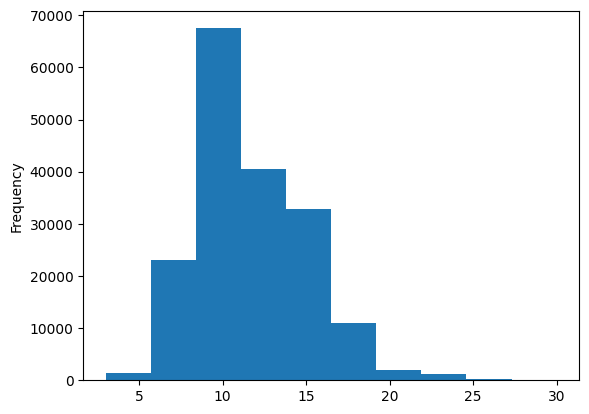

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
train_sentences=train_df["text"].tolist()
val_sentences=val_df["text"].tolist()
test_sentences=test_df["text"].tolist()

#Using One hot encodr and Label Encoders on target column of dataframe
Convert text to numeric label

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse=False)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot=one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot=one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded=label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded= label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Model 0 getting a basic model
Using a tf-idf multinomial Naive Bayes using scikit- learn and classify sentence usinf Multinomial NAive BAyes algorithmn

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0=Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

In [ ]:
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2023-08-02 16:46:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-02 16:46:49 (110 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import *

In [ ]:
baseline_preds=model_0.predict(val_sentences)

Calculateing model performance using helper functions

In [ ]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
#model_0.save("./content/drive/MyDrive/skimlit_model/model_0.h5")

#Next step is to prepare our data deep sequence models
using vectorization anf embedding layers to convert text to numbers and capture relationship between those numbers

In [ ]:
import numpy as np
from tensorflow.keras import layers
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

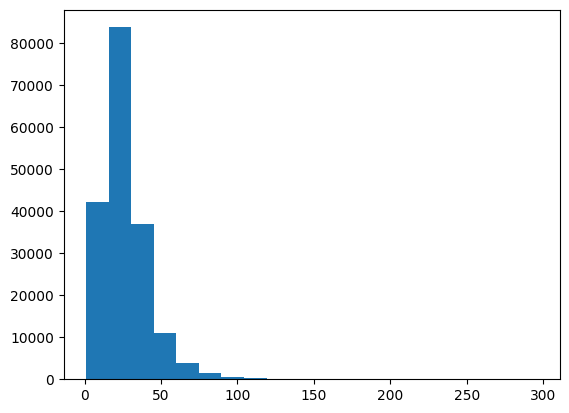

In [ ]:
plt.hist(sent_lens,bins=20)

In [ ]:
max_tokens =68000

In [ ]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len


55

#Create text vectorizer
Keeping all parameters except all max_tokens and output_sequence_length

In [ ]:
from tensorflow.keras.layers import TextVectorization
text_vectorizer=TextVectorization(max_tokens=max_tokens,
                                  output_sequence_length=55)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:

import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")


Text:
a multisite randomized controlled trial was conducted comparing the cognitive behavioral analysis system of psychotherapy ( cbasp ) , a psychotherapy model developed specifically to treat chronic depression ( n = @ ) with care as usual ( cau ; evidence-based treatments , n = @ ) over a period of @ weeks , with @ sessions on average , in @ outpatient clinics in the netherlands .

Length of text: 68

Vectorized text:
[[    8  4066    29   106    32    10   198   582     2   301   706    85
    355     4  2205 21018     8  2205   314   481  1850     6   733   244
    255    40     7    77    25   370 11713  1439   377    40   145     8
    173     4    53     7   416    18   405     5  1058  1364     5     2
   2224     0     0     0     0     0     0]]


In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

#Create custom text embedding
Pass the vectorized sentence to a text embedding to capture relationship between words

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding")

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
a multisite randomized controlled trial was conducted comparing the cognitive behavioral analysis system of psychotherapy ( cbasp ) , a psychotherapy model developed specifically to treat chronic depression ( n = @ ) with care as usual ( cau ; evidence-based treatments , n = @ ) over a period of @ weeks , with @ sessions on average , in @ outpatient clinics in the netherlands .

Sentence after vectorization (before embedding):
[[    8  4066    29   106    32    10   198   582     2   301   706    85
    355     4  2205 21018     8  2205   314   481  1850     6   733   244
    255    40     7    77    25   370 11713  1439   377    40   145     8
    173     4    53     7   416    18   405     5  1058  1364     5     2
   2224     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.04269317 -0.03702974  0.0066505  ... -0.04312685  0.004175
   -0.02112132]
  [ 0.00743973  0.0453534  -0.03096616 ...  0.01672549  0.00193596
   -0.00130186]
  [-0

# Create datasets
Prepare datset for training this decreses load times of data into GPU
This optimizes traffic flow and prefetches datas to improve efficienty

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))


In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# **Model 1:Con1D with tiken embeddings**


In [ ]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
len(train_dataset)*0.1

562.7

In [ ]:
len(valid_dataset)

945

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 50s 65ms/step - loss: 0.9187 - accuracy: 0.6400 - val_loss: 0.6863 - val_accuracy: 0.7453
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6554 - accuracy: 0.7579 - val_loss: 0.6281 - val_accuracy: 0.7736
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.6157 - accuracy: 0.7757 - val_loss: 0.5929 - val_accuracy: 0.7862


In [ ]:
model_1_preds_probs=model_1.predict(valid_dataset)
model_1_preds_probs.shape

945/945 [==============================] - 2s 2ms/step


(30212, 5)

In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.5958 - accuracy: 0.7864


[0.5957603454589844, 0.7864093780517578]

In [ ]:
model_1_preds = tf.argmax(model_1_preds_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.64093737587714,
 'precision': 0.7832133188317709,
 'recall': 0.7864093737587714,
 'f1': 0.7840304467097255}

In [ ]:
#model_1.save("./content/drive/MyDrive/skimlit_model/model_1.h5")

NotImplementedError: ignored

# **Model 2 :Feature extraction with pretrained token embeddings**
Feature extraction with pretrained token embedding
training embedding layer from scratch increses training time
so a pretrained embedding layer trained on a bigger datase tand is tested and well optimized

here we take pretrained Universal Sentence Encoder embedding from TensorflowHub
setting  
**trainable =False **
for this model set up


In [ ]:

# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
random_train_sentence=random.choice(train_sentences)
use_embedded_sentence=tf_hub_embedding_layer([random_train_sentence])
print(f"random text:{random_train_sentence}")

random text:group i was injected @ mg of methylprednisolone acetate into the masseter muscle via the intrabuccal approach , one hour before the surgery .


In [ ]:
inputs=layers.Input(shape=[],dtype=tf.string)
text_vectors = text_vectorizer(inputs)
x=tf_hub_embedding_layer(inputs)
x=layers.Dense(128,activation="relu")(x)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_2=tf.keras.Model(inputs=inputs,
                       outputs=outputs,
                       name="model_2_use_Feature_extractor_layer")
model_2.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_model_2=model_2.fit(train_dataset,
                          steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                                      epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 17ms/step - loss: 0.9164 - accuracy: 0.6499 - val_loss: 0.8000 - val_accuracy: 0.6868
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7727 - accuracy: 0.6986 - val_loss: 0.7603 - val_accuracy: 0.7041
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7584 - accuracy: 0.7105 - val_loss: 0.7443 - val_accuracy: 0.7118


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.7464 - accuracy: 0.7117


[0.7463845610618591, 0.7117370367050171]

In [ ]:
model_2_pred_probs=model_2.predict(valid_dataset)
model_2_preds=tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

In [ ]:
model_2_result=calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_result

In [ ]:
#model_2.save("/content/drive/MyDrive/skimlit_model/model_0.h5")

# **model 3: Conv1D with character embeddings**
# Creating a character-level tokenizer
character embedding is layers which encoded characteristic between each letters in a word



In [ ]:
def split_char(text):
  return " ".join(list(text))
split_char(random_train_sentence)

'p a r e n t e r a l   n u t r i t i o n   (   p n   )   i s   u s u a l l y   a d m i n i s t e r e d   d u r i n g   a l l o - h s c t   ,   e s s e n t i a l l y   f o r   p r a c t i c a l   r e a s o n s   .'

In [ ]:
train_chars=[split_char(s) for s in train_sentences]
val_chars=[split_char(s) for s in val_sentences]
test_chars=[split_char(s) for s in test_sentences]

In [ ]:
import string
alphabets=string.ascii_lowercase+string.digits + string.punctuation

In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
NUM_CHAR_TOKENS=len(alphabets)+2
char_vectorizer=TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                  output_sequence_length=output_seq_char_len,
                              #    standardize="lower_and_strip_procedure"
                                  name="char_vectorizers")

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()


# Creating a character-level embedding

In [ ]:
char_embed=layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3=tf.keras.Model(inputs=inputs,outputs=outputs,name="model_3_char_tokenisation")


In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
model_3.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3_history=model_3.fit(train_dataset,
                          steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                                      epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 8s 12ms/step - loss: 1.3674 - accuracy: 0.4309 - val_loss: 1.3321 - val_accuracy: 0.4355
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.3242 - accuracy: 0.4268 - val_loss: 1.3213 - val_accuracy: 0.4365
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 1.3195 - accuracy: 0.4365 - val_loss: 1.3251 - val_accuracy: 0.4352


In [ ]:
model_3.evaluate(valid_dataset)

945/945 [==============================] - 6s 7ms/step - loss: 1.3139 - accuracy: 0.4395


[1.313943862915039, 0.43952733278274536]

In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.00283362, 0.00373341, 0.09497985, 0.00185807, 0.89659506],
       [0.00489654, 0.00541224, 0.12847081, 0.00289063, 0.8583298 ],
       [0.00441784, 0.00524929, 0.12779117, 0.00245882, 0.8600828 ],
       ...,
       [0.00304015, 0.0034336 , 0.09829532, 0.00194262, 0.8932883 ],
       [0.00261302, 0.00273433, 0.09371949, 0.001477  , 0.89945614],
       [0.00334658, 0.00357653, 0.07894199, 0.0024202 , 0.91171473]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([4, 4, 4, ..., 4, 4, 4])>

In [ ]:

# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 33.744869588243084,
 'precision': 0.2303085650017141,
 'recall': 0.3374486958824308,
 'f1': 0.2121391170097048}

# **model 4: adding token embedding along with character embedding as an input to the model**
concat token embedding model

In [ ]:
#model 1 token embeddding
token_inputs=layers.Input(shape=[],dtype=tf.string)
token_embeddings=tf_hub_embedding_layer(token_inputs)
token_output=layers.Dense(128,activation="relu")(token_embeddings)
token_model=tf.keras.Model(inputs=token_inputs,
                           outputs=token_output)
#model2 char embedding
char_inputs=layers.Input(shape=(1,),dtype=tf.string,name='char_inputs')
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)
#add token and char input
token_char_concat=layers.Concatenate(name="token_char_hybrid",)([token_model.output,char_model.output])

#create rest of the layers
combined_dropout=layers.Dropout(0.5)(token_char_concat)
combined_dense= layers.Dense(200,activation="relu")(combined_dropout)
final_dropout=layers.Dropout(0.5)(combined_dense)
output_layer=layers.Dense(num_classes,activation="softmax")(final_dropout)

model_4=tf.keras.Model(inputs=[token_model.input,char_model.input],
                       outputs=output_layer,
                       name="model_4_token_and_char_embedding")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 char_vectorizers (TextVectoriz  (None, 290)         0           ['char_inputs[0][0]']            
 ation)                                                                                           
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['

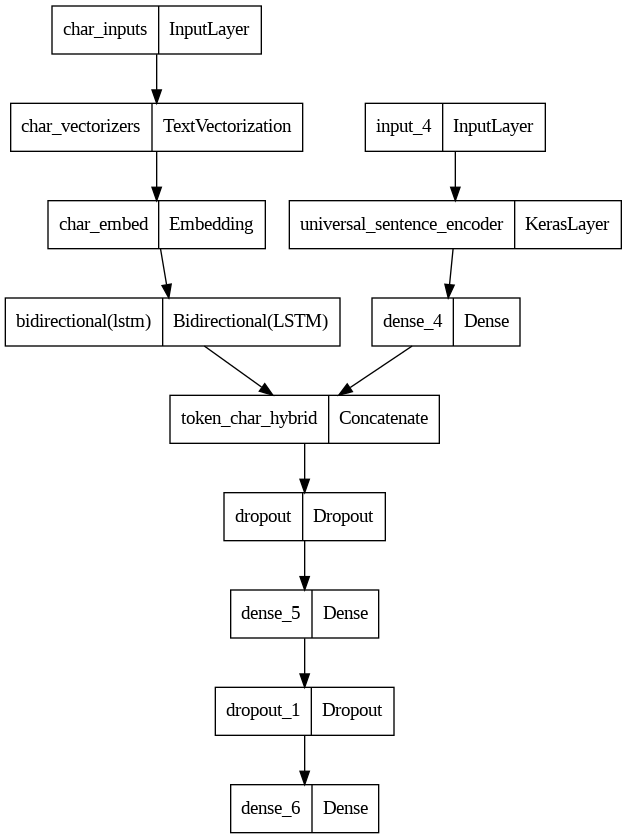

In [ ]:
from keras.utils import plot_model
plot_model(model_4,show_shapes=False)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_char_token_dataset,val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_model_4=model_4.fit(train_char_token_dataset,
                            steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                            epochs=3,
                            validation_data=val_char_token_dataset,
                            validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 34s 48ms/step - loss: 0.9776 - accuracy: 0.6132 - val_loss: 0.7901 - val_accuracy: 0.6968
Epoch 2/3
562/562 [==============================] - 25s 45ms/step - loss: 0.7978 - accuracy: 0.6902 - val_loss: 0.7204 - val_accuracy: 0.7244
Epoch 3/3
562/562 [==============================] - 27s 49ms/step - loss: 0.7733 - accuracy: 0.7035 - val_loss: 0.6986 - val_accuracy: 0.7347


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.6998 - accuracy: 0.7327


[0.6997705698013306, 0.7327221035957336]

In [ ]:
model_4_pred_probs=model_4.predict(val_char_token_dataset)

945/945 [==============================] - 20s 20ms/step


In [ ]:
model_4_preds=tf.argmax(model_4_pred_probs,axis=1)
model_4_preds
model_4_results=calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_4_preds)
model_4_results

{'accuracy': 73.27220971799285,
 'precision': 0.734312324366993,
 'recall': 0.7327220971799285,
 'f1': 0.7306676685096384}

# **model 5: adding token embedding ,character embedding , line number as an input to the model**

In [ ]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [ ]:
tarin_line_numbers_one_hot=tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot=tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df["line_number"].to_numpy(),depth=15)

<Axes: ylabel='Frequency'>

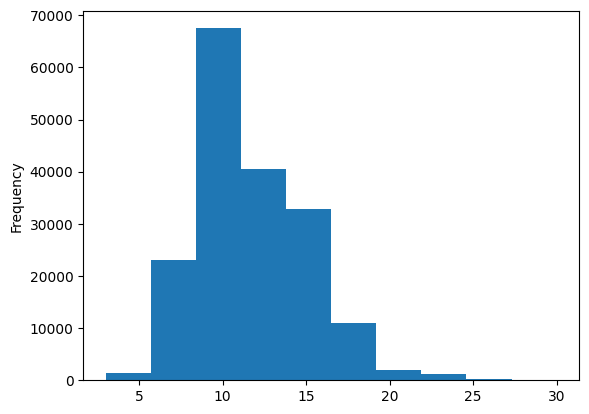

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
train_total_lines_one_hot=tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot=tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)

In [ ]:

# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

model_5 =tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)


In [ ]:
model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizers (TextVectoriz  (None, 290)         0           ['char_inputs[0][0]']            
 ation)                                                                                           
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

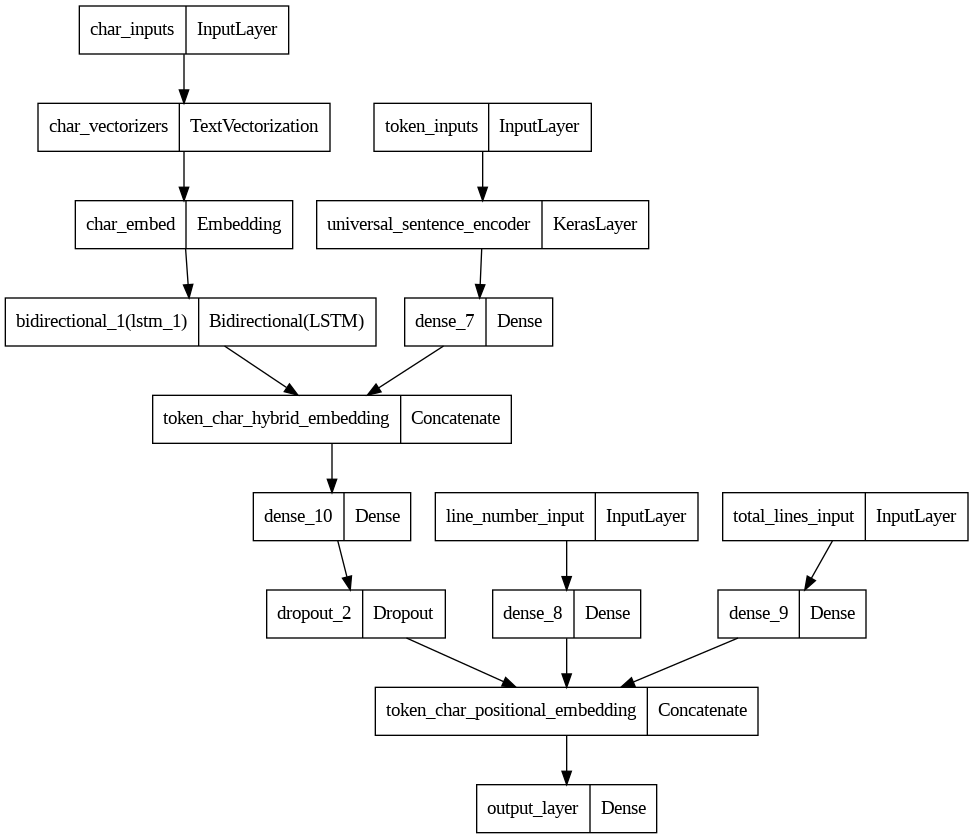

In [ ]:
from keras.utils import plot_model
plot_model(model_5,show_shapes=False)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
'''train_char_token_pos_data=tf.data.Dataset.from_tensor_slices((tarin_line_numbers_one_hot,
                                           train_total_lines_one_hot,
                                           train_sentences,
                                           train_chars))
train_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset=tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))
train_char_token_pos_dataset=train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data=tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                           val_total_lines_one_hot,
                                           val_sentences,
                                           val_chars))
val_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
val_char_token_pos_dataset=tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))
val_char_token_pos_dataset=val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

'''

'train_char_token_pos_data=tf.data.Dataset.from_tensor_slices((tarin_line_numbers_one_hot,\n                                           train_total_lines_one_hot,\n                                           train_sentences,\n                                           train_chars))\ntrain_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)\ntrain_char_token_pos_dataset=tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))\ntrain_char_token_pos_dataset=train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)\n\nval_char_token_pos_data=tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,\n                                           val_total_lines_one_hot,\n                                           val_sentences,\n                                           val_chars))\nval_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)\nval_char_token_pos_dataset=tf.data.Dataset.zip((val_char_token_pos_data,

In [ ]:

# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((tarin_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
train_pos_char_token_dataset,val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_model_5=model_5.fit(train_pos_char_token_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.1*len(train_pos_char_token_dataset)),
                            validation_data=val_pos_char_token_dataset,
                            validation_steps=int(0.1*len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 34s 47ms/step - loss: 1.0976 - accuracy: 0.7231 - val_loss: 0.9846 - val_accuracy: 0.8062
Epoch 2/3
562/562 [==============================] - 32s 57ms/step - loss: 0.9682 - accuracy: 0.8134 - val_loss: 0.9536 - val_accuracy: 0.8238
Epoch 3/3
562/562 [==============================] - 26s 46ms/step - loss: 0.9502 - accuracy: 0.8237 - val_loss: 0.9399 - val_accuracy: 0.8288


In [ ]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))


Epoch 1/3
562/562 [==============================] - 19s 34ms/step - loss: 0.9431 - accuracy: 0.8303 - val_loss: 0.9319 - val_accuracy: 0.8358
Epoch 2/3
562/562 [==============================] - 19s 33ms/step - loss: 0.9246 - accuracy: 0.8454 - val_loss: 0.9234 - val_accuracy: 0.8464
Epoch 3/3
562/562 [==============================] - 18s 33ms/step - loss: 0.9198 - accuracy: 0.8473 - val_loss: 0.9259 - val_accuracy: 0.8368


In [ ]:
model_5_pred_probs=model_5.predict(val_pos_char_token_dataset,verbose=1)
model_5_pred_probs

945/945 [==============================] - 18s 17ms/step


array([[0.49331805, 0.0843354 , 0.01211106, 0.3910418 , 0.01919369],
       [0.51775914, 0.10227606, 0.06080849, 0.30504408, 0.01411226],
       [0.3118951 , 0.09850772, 0.08640458, 0.4461677 , 0.05702489],
       ...,
       [0.03373111, 0.0914883 , 0.03081355, 0.03203745, 0.8119296 ],
       [0.02479896, 0.2835295 , 0.0628197 , 0.0276562 , 0.60119563],
       [0.15307605, 0.7518583 , 0.02972007, 0.02938014, 0.03596543]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 84.14868264265854,
 'precision': 0.8405975199467953,
 'recall': 0.8414868264265855,
 'f1': 0.8404611692441419}

compare model result

In [ ]:
all_model_results=pd.DataFrame({"model_0_basline":baseline_results,
                                "model_1_custom_token_embedding":model_1_results,
                                "model_2_pretrained_token_embedding":model_2_result,
                                "model_3_custom_char_embedding":model_3_results,
                                "model_4_hybrid_char_token_embedding":model_4_results,
                                "model_5_trihybrid_with_positional_embedding":model_5_results})
all_model_results=all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_basline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.528399,0.781753,0.785284,0.782619
model_2_pretrained_token_embedding,71.124057,0.711209,0.711241,0.708405
model_3_custom_char_embedding,33.744870,0.230309,0.337449,0.212139
model_4_hybrid_char_token_embedding,73.272210,0.734312,0.732722,0.730668
model_5_trihybrid_with_positional_embedding,84.148683,0.840598,0.841487,0.840461


In [ ]:
all_model_results["accuracy"] =all_model_results["accuracy"]/100

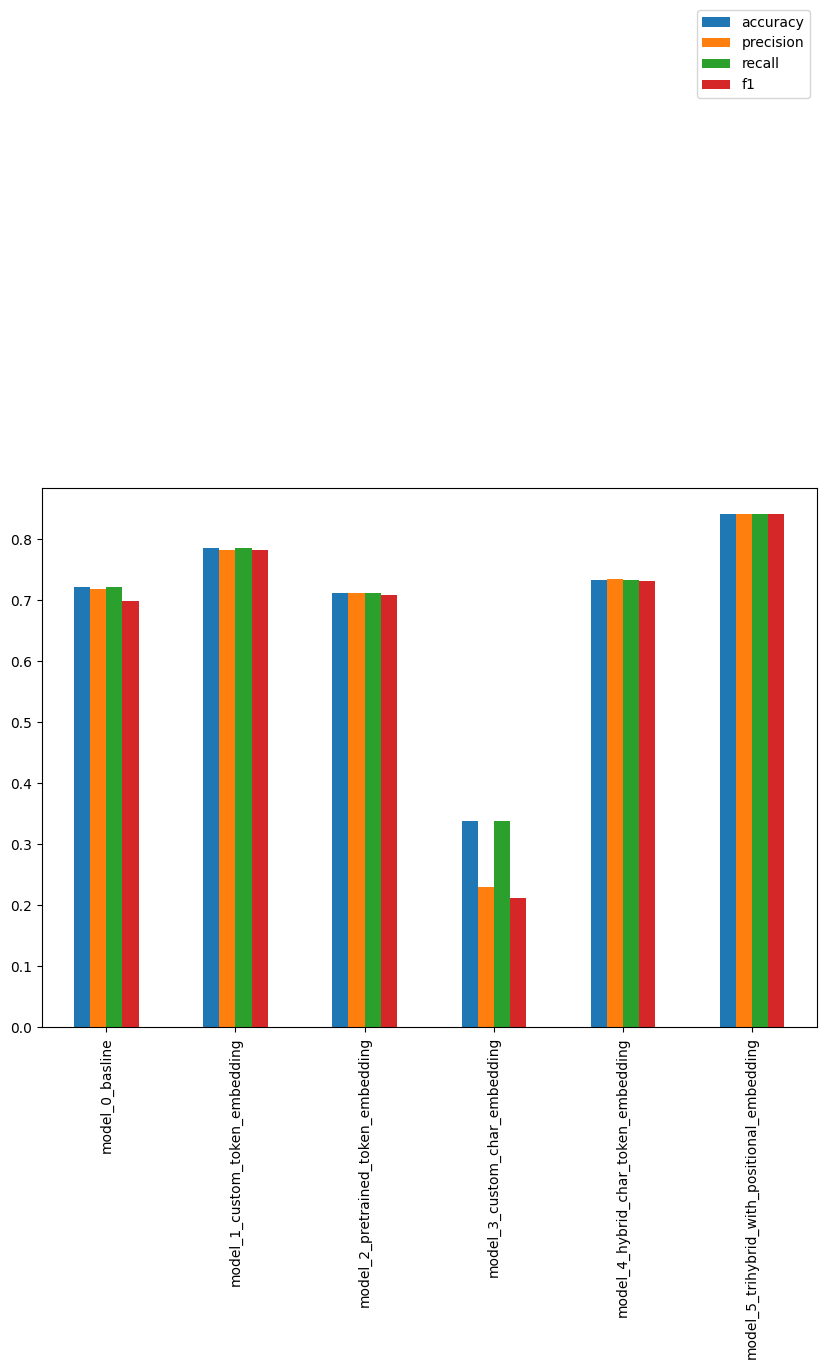

In [ ]:
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.9))

<Axes: >

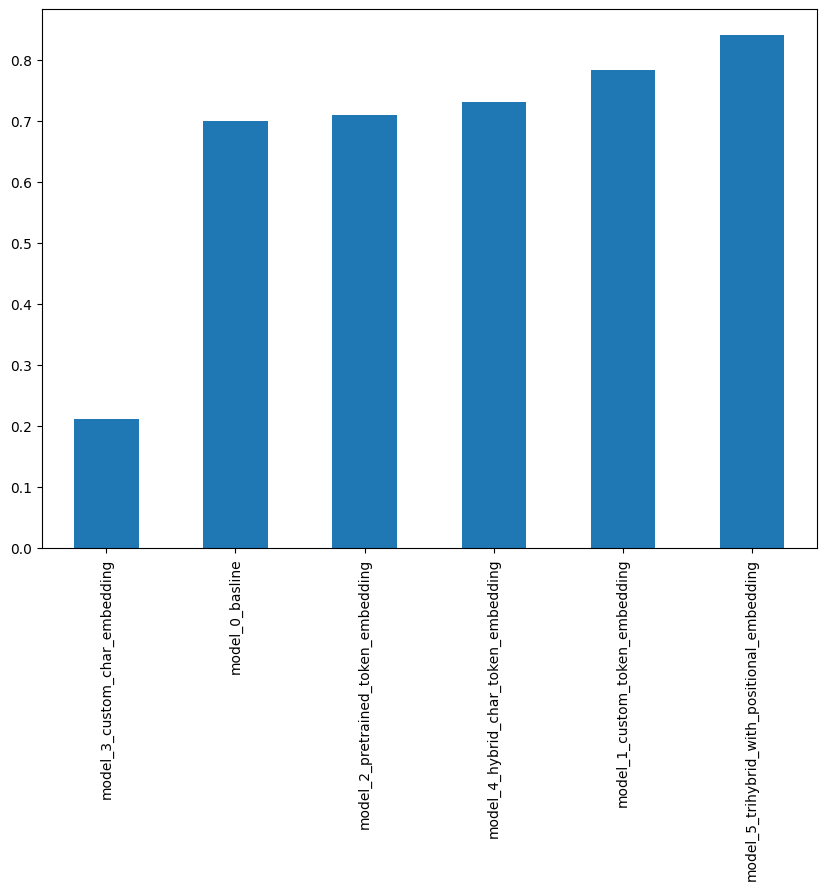

In [ ]:
all_model_results.sort_values("f1",ascending=True)["f1"].plot(kind="bar",figsize=(10,7))

In [ ]:
model_5.save("skimlit_tribrid_model")

In [ ]:
loaded_model=tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
loaded_pred_probs=loaded_model.predict(val_pos_char_token_dataset)
loaded_preds=tf.argmax(loaded_pred_probs)

945/945 [==============================] - 18s 18ms/step


In [ ]:
loaded_model_results=calculate_results(y_true=val_labels,
                                       y_pred=loaded_preds)
loaded_model

NameError: ignored

In [ ]:
model_5_results

{'accuracy': 84.14868264265854,
 'precision': 0.8405975199467953,
 'recall': 0.8414868264265855,
 'f1': 0.8404611692441419}